**目前只能預測一次的落點...  
因為當初先用找到的資料，所以物理模型的資料放在比較後面，目前只測試第一筆第一個落地點  
而且還沒到可以完全自動化去計算的程度**

**目錄**
* [Part1. 網路資料](#Part1.網路資料)
    * [資料匯入與處理](#讀取+處理資料)
    * [3D軌跡圖](#3D軌跡圖)
    * [位移與速度作圖](#座標（位移）作圖)
    * [線性迴歸](#單變量線性迴歸)
    * [軌跡預測](#軌跡預測)
    * [預測結果作圖](#預測結果作圖)
    * [計算殘差](#計算各軸殘差平方和（誤差平方和）)
    * [落點預測](#落點預測)
* [Part2. 物理模型~](#Part2.物理模型~)
    * [資料匯入與處理](#讀取資料（目前只測試第一筆）)
    * [3D軌跡圖](#繪製3D軌跡圖)
    * [位移與速度作圖](#三軸座標（位移）作圖)
    * [線性迴歸](#建立線性迴歸模型並作圖)
    * [軌跡預測](#軌跡預測分析)
    * [預測結果作圖](#預測結果繪製)
    * [計算殘差](#計算殘差平方和（誤差平方和）)
    * [落點預測](#落點預測（座標＋時間）)
    

**函式整理**    
* [作3D軌跡圖用: plot_3D](#plot_3D函式)   
* [作位移速度圖用: plot_result](#plot_result函式)
* [單變量線性回歸用: linear_regression](#linear_regression函式)
* [預測軌跡用(Part1.): trajectory_](#trajectory_函式)
* [計算殘差平方和用(Part1.): SSE_](#SSE_函式)
* [牛頓迭代法: Newton](#Newton函式)
* [預測軌跡用(Part2.): trajectory](#trajectory函式)
* [預測軌跡用: trajectory2](#trajectory2函式)
* [計算殘差平方和用(Part2.): SSE](#SSE函式)

In [1]:
#import matplotlib.pyplot as plt  
#plt.style.use('dark_background')

# Part1.網路資料
用 https://github.com/amrut-prabhu/table-tennis-ball-trajectory 上經處理後的三軸座標中的第 4 筆資料（3dpts_3.csv）

## 讀取+處理資料

In [2]:
import pandas as pd
traj = pd.read_csv("3dpts_3.csv") 
column = traj.columns
aa = pd.DataFrame([[float(i) for i in traj.columns]]).rename(columns = {0: 'x', 1: 'y', 2: 'z'})
traj = traj.rename(columns = {column[0]: 'x', column[1]: 'y', column[2]: 'z'})
traj = pd.concat([aa, traj], ignore_index=True)
traj.head()

,x,y,z
0,-0.95834,-0.034627,0.35342
1,-0.89166,-0.034825,0.36821
2,-0.82773,-0.034802,0.37475
3,-0.76749,-0.033297,0.38669
4,-0.69797,-0.039568,0.39782


## savgol filter 

In [3]:
from scipy.signal import savgol_filter
import numpy as np
np.set_printoptions(precision=4) 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
X = savgol_filter(traj['x'],5,1)
Y = savgol_filter(traj['y'],5,1)
Z = savgol_filter(traj['z'],5,1)

In [4]:
traj_after = pd.concat([pd.Series(X), pd.Series(Y), pd.Series(Z)], axis = 1)
traj_after = traj_after.rename(columns = {0: 'x', 1: 'y', 2: 'z'})
traj_after.head()

,x,y,z
0,-0.957620,-0.033753,0.354722
1,-0.893129,-0.034588,0.365450
2,-0.828638,-0.035424,0.376178
3,-0.765266,-0.036634,0.386776
4,-0.703392,-0.036187,0.395896


## 3D軌跡圖
### plot_3D函式

In [5]:
def plot_3D(X, Y, Z):
    import numpy as np
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    xdata = X
    ydata = Y
    zdata = Z
    ax.scatter3D(xdata, ydata, zdata, c='r')

    ax.set_xlabel('$X$', fontsize = 15)
    ax.set_ylabel('$Y$', fontsize = 15)
    ax.set_zlabel('$Z$', fontsize = 15)

- 整體

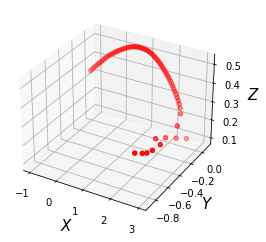

In [6]:
plot_3D(X, Y, Z)
# X = np.array(traj_after['x']) vice versa

- 片段（取到第 60 列）  
基於取到第 60 列的曲線較符合預期的樣子，因此後續處理會以取到第 60 列來作基準

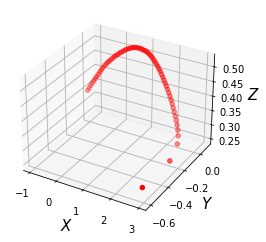

In [7]:
plot_3D(X[:65], Y[:65], Z[:65])

In [8]:
traj_after.iloc[60:65]

,x,y,z
60,2.23604,0.054715,0.275212
61,2.31644,0.033441,0.262412
62,2.44616,-0.020164,0.251454
63,2.71546,-0.204283,0.251192
64,2.96016,-0.606671,0.284770


## 座標（位移）作圖

### plot_result函式

In [9]:
def plot_result(X1data, Y1data, title, xlab, ylab, label, X2data=None, Y2data=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,3))
    for i in range(len(Y1data)):
        plt.subplot(1, len(Y1data), i+1)
        plt.plot(X1data, Y1data[i], label=label[0])
        if Y2data != None:
            plt.plot(X2data, Y2data[i], label=label[1])
        plt.title(title[i])
        plt.xlabel(xlab[i])
        plt.ylabel(ylab[i])
        plt.tight_layout()
        plt.legend(loc='best')

- 整體

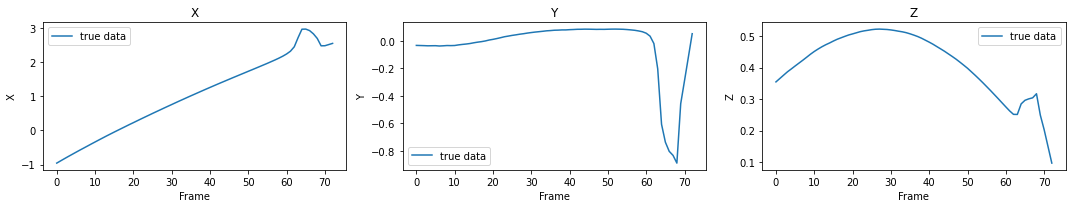

In [10]:
plot_result(traj_after.index, [X, Y, Z], ['X', 'Y', 'Z'], ['Frame', 'Frame', 'Frame'], ['X', 'Y', 'Z'], ['true data'])

- 片段（取到第 60 列）

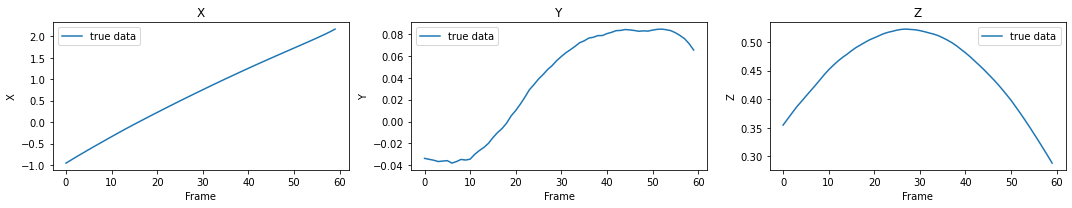

In [11]:
plot_result(traj_after.index[:60], [X[:60], Y[:60], Z[:60]], ['X', 'Y', 'Z'], ['Frame', 'Frame', 'Frame'], ['X', 'Y', 'Z'], ['true data'])

## 座標變化量（速度）作圖

- 整體

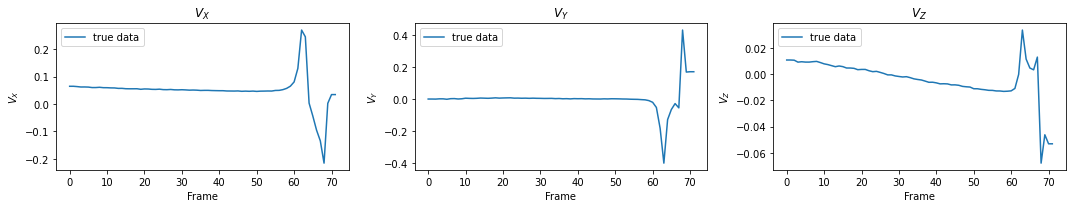

In [12]:
# https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array
from scipy.ndimage.interpolation import shift
VX = shift(X, -1, cval=np.NaN) - X
VY = shift(Y, -1, cval=np.NaN) - Y
VZ = shift(Z, -1, cval=np.NaN) - Z
plot_result(traj_after.index, [VX, VY, VZ], ['$V_X$', '$V_Y$', '$V_Z$'], ['Frame', 'Frame', 'Frame'], ['$V_X$', '$V_Y$', '$V_Z$'], ['true data'])

- 片段（取到第 60 列）

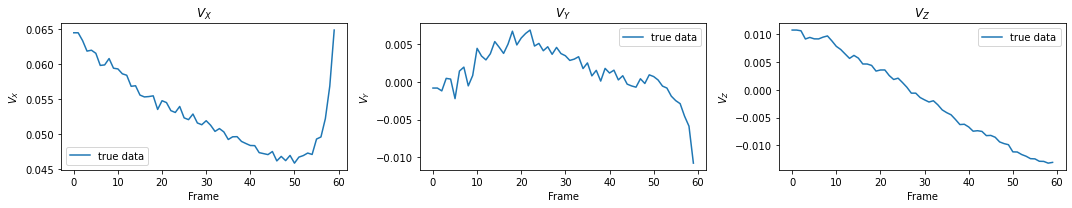

In [13]:
plot_result(traj_after.index[:60], [VX[:60], VY[:60], VZ[:60]], ['$V_X$', '$V_Y$', '$V_Z$'], ['Frame', 'Frame', 'Frame'], ['$V_X$', '$V_Y$', '$V_Z$'], ['true data'])

## 單變量線性迴歸

原本線性迴歸代號如下，$\hat\beta$ 為估計的參數
$$
\hat y=X\hat\beta
$$
$$
\hat\beta = \left( X^T X \right)^{-1} X^T Y 
$$
改為$Ax=b$的型式
$$
\hat X = \left( A^T A \right)^{-1} A^T b 
$$
where, 
$$
A =
 \left[
 \begin{matrix}
   1      & a_{11} & a_{12} &  \cdots  &  a_{1m} \\
   1      & a_{21} & a_{22} &  \cdots  &  a_{2m} \\
   \vdots & \vdots & \vdots &  \ddots  &  \vdots \\
   1      & a_{n1} & a_{n2} &  \cdots  &  a_{nm} \\
  \end{matrix}
  \right]
$$
這裡用單變量，所以 $m=1$。

假設要對 Z 座標進行線性迴歸，以$Z_1$代表第一個記錄點的 Z 座標
$$
b =
 \left[
 \begin{matrix}
   Z_1    \\
   Z_2    \\
   \vdots \\
   Z_n    \\
  \end{matrix}
  \right]
$$

最後計算出的$\hat X$代表迴歸所得到的參數，分別為常數項和一次項。

### linear_regression函式
**想加label但不知為何沒辦法如預期結果一樣**

In [14]:
def linear_regression(name, data_X, data_Y, label=[None, None]):
    import numpy as np
    import matplotlib.pyplot as plt  
    b = data_Y
    A = np.array(data_X).reshape(len(data_X), -1)
    A = np.hstack((np.ones((len(b), 1)), A))
    x = np.linalg.inv(A.transpose().dot(A)).dot(A.transpose()).dot(b)   # x = [intercept, slope]
    r = b-A.dot(x)
    
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(data_X, b, label=label[0])
    abline_values = [x[1]*i + x[0] for i in data_X]
    ax.plot(data_X, abline_values, label=label[1])
    ax.legend('best')
    ax.set_title(name[0])
    ax.set_xlabel(name[1])
    ax.set_ylabel(name[2])
    
    
    text = name[2] + ' = ' + str(round(x[0], 4)) + '+' + str(round(x[1], 4)) + '*' + name[1] + '\n$\Vert r \Vert_2$ =' + str(round(np.linalg.norm(r), 4))
    # norm 預設為2
    ax.text(0.1, 0.5, text,size=15, color='green', transform = ax.transAxes)
    # https://stackoverflow.com/questions/8482588/putting-text-in-top-left-corner-of-matplotlib-plot
    return(x[1], x[0], r)   


- **針對第10列~第29列的 X, Y, Z 座標進行線性迴歸（假設我們只知道這段區間球的座標資料）**  
PS.區間取太小或太偏 (?) Z座標用線性迴歸就會很好 （切線的概念）（？）

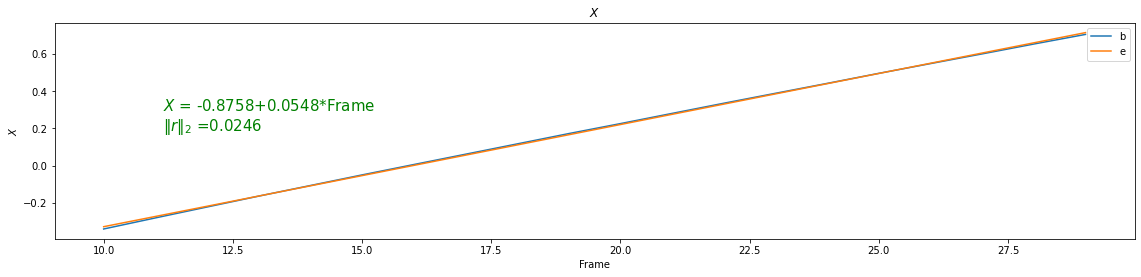

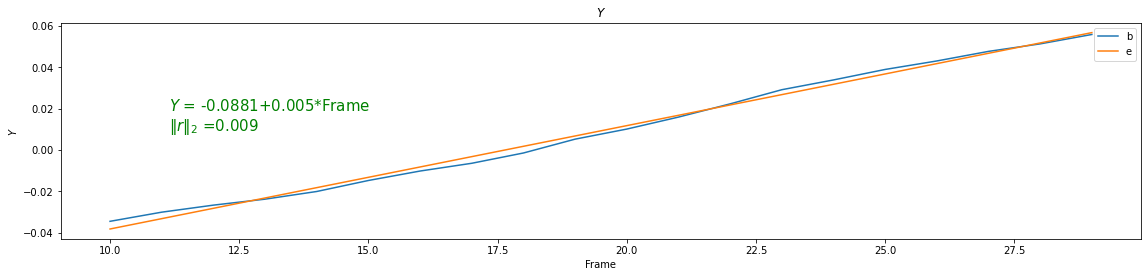

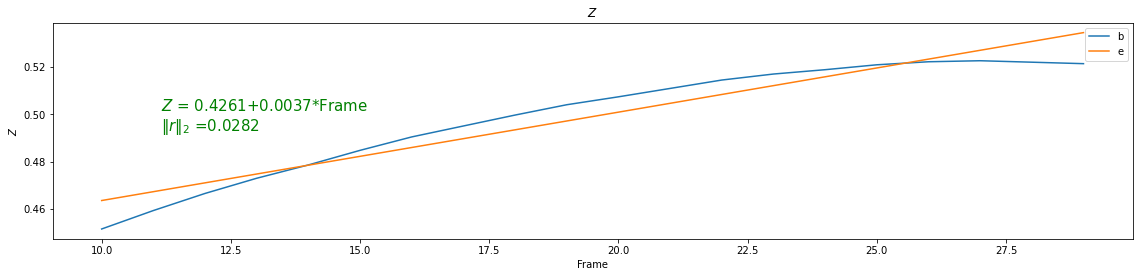

In [15]:
slope_X, intercept_X, r_X = linear_regression(['$X$', 'Frame', '$X$'], traj_after.index[10:30], X[10:30], ['true data', 'prediction'])
slope_Y, intercept_Y, r_Y = linear_regression(['$Y$', 'Frame', '$Y$'], traj_after.index[10:30], Y[10:30], ['true data', 'prediction'])
slope_Z, intercept_Z, r_Z = linear_regression(['$Z$', 'Frame', '$Z$'], traj_after.index[10:30], Z[10:30], ['true data', 'prediction'])

- **針對第10列~第28列的 Y, Z 座標變化量（速度）進行線性迴歸（將我們得到的座標換算成速度）**

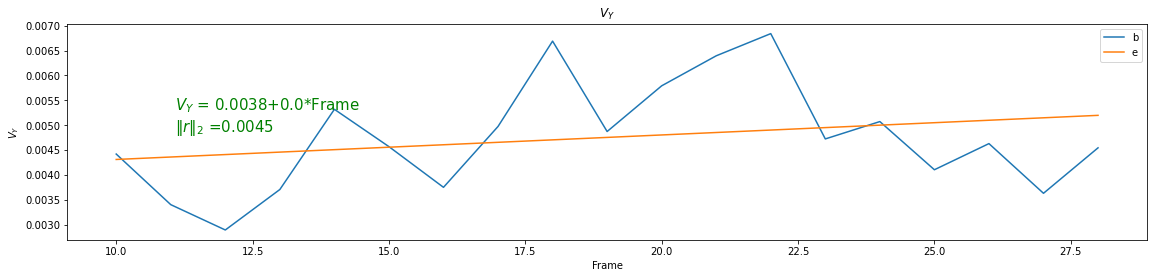

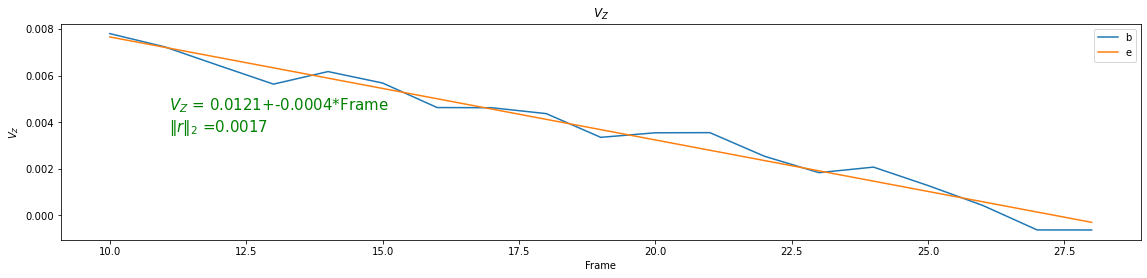

In [16]:
#from scipy.ndimage.interpolation import shift
#VY = shift(Y, -1, cval=np.NaN) - Y
slope_VY, intercept_VY, r_VY = linear_regression(['$V_Y$', 'Frame', '$V_Y$'], traj_after.index[10:29], VY[10:29], ['true data', 'prediction'])
#from scipy.ndimage.interpolation import shift
#VZ = shift(Z, -1, cval=np.NaN) - Z
slope_VZ, intercept_VZ, r_VZ = linear_regression(['$V_Z$', 'Frame', '$V_Z$'], traj_after.index[10:29], VZ[10:29], ['true data', 'prediction'])

## 軌跡預測

假設 $Vz$ 不變的情況下，每過 t 秒，位置與速度的變化
$$
 \left[
 \begin{matrix}
   x_{n+1} \\
   y_{n+1} \\
   z_{n+1} \\
   V_x \\
   V_y \\
   V_z 
  \end{matrix}
  \right]
=
 \left[
 \begin{matrix}
   1 & 0 & 0 & t & 0 & 0 \\
   0 & 1 & 0 & 0 & t & 0 \\
   0 & 0 & 1 & 0 & 0 & t \\
   0 & 0 & 0 & 1 & 0 & 0 \\
   0 & 0 & 0 & 0 & 1 & 0 \\
   0 & 0 & 0 & 0 & 0 & 1 \\
  \end{matrix}
  \right]
 \left[
 \begin{matrix}
   x_{n} \\
   y_{n} \\
   z_{n} \\
   V_x \\
   V_y \\
   V_z 
  \end{matrix}
  \right]
$$

每過 t 秒，$Vz$ 的變化
$$
 \left[
 \begin{matrix}
   Vz_{n+1} \\
   -g \\
  \end{matrix}
  \right] 
=
 \left[
 \begin{matrix}
   1 & t \\
   0 & 1 \\
  \end{matrix}
  \right]
 \left[
 \begin{matrix}
   Vz_{n} \\
   -g \\
  \end{matrix}
  \right]   
=
 \left[
 \begin{matrix}
   Vz_{n} - tg \\
   -g \\
  \end{matrix}
  \right] 
$$


合在一起來看的話
$$
 \left[
 \begin{matrix}
   x_{n+1} \\
   y_{n+1} \\
   z_{n+1} \\
   V_x \\
   V_y \\
   Vz_{n+1} \\
   -g
  \end{matrix}
  \right]
=
 \left[
 \begin{matrix}
   1 & 0 & 0 & t & 0 & 0 & 0\\
   0 & 1 & 0 & 0 & t & 0 & 0\\
   0 & 0 & 1 & 0 & 0 & t & 0\\
   0 & 0 & 0 & 1 & 0 & 0 & 0\\
   0 & 0 & 0 & 0 & 1 & 0 & 0\\
   0 & 0 & 0 & 0 & 0 & 1 & t\\
   0 & 0 & 0 & 0 & 0 & 0 & 1\\
  \end{matrix}
  \right]
 \left[
 \begin{matrix}
   x_{n} \\
   y_{n} \\
   z_{n} \\
   V_x \\
   V_y \\
   Vz_n \\
   -g \\
  \end{matrix}
  \right]
$$
  
上述提到的 $g$ 不一定要是 $9.8m/s^2$，而是從 V_z 的變化量（迴歸斜率）來代入。  
後面是用 $\Delta t$ （預測區間差）來作為這裡所提到的 $t$。

### trajectory_函式
**這裡假設 X, Y 的速度為定值的情況，且最低高度（碰到桌面時的 Z 座標）為`traj_after['z'].iloc[60]=0.2752`**  
此軌跡預測函數 trajectory_ 與後面物理模型測試區的 trajectory, trajectory2 有些微差異  

In [17]:
# 分開來看 (分成上面提到的前兩個矩陣的部分)
# 因為假設 VX, VY 為定值，因此用迴歸係數帶入而不能用資料點的座標相減而得(X, Y 座標前後相減所得到的速度並非定值)
def trajectory_(delta_t, X, Y, Z, g, index, VX0=None, VY0=None, zlimit=0):
    matrix = np.diag(np.array([1.,1.,1.,1.,1.,1.])) + np.diag(np.array([delta_t,delta_t,delta_t]), k=3)
    matrix_Z = np.array([[1,delta_t], [0,1]])
    if VX0 == None:
        VX0 = (X.iloc[index+1]-X.iloc[index])/(X.index[index+1]-X.index[index])
    if VY0 == None:
        VY0 = (Y.iloc[index+1]-Y.iloc[index])/(X.index[index+1]-X.index[index])
    VZ0 = (Z.iloc[index+1]-Z.iloc[index])/(X.index[index+1]-X.index[index])
    VZ = np.array([VZ0, g])
    
    state = np.array([X.iloc[index], Y.iloc[index], Z.iloc[index], VX0, VY0, VZ0])
    df = pd.DataFrame([state], columns=['X', 'Y', 'Z', '$V_X$(m/s)', '$V_Y$(m/s)', '$V_Z$(m/s)'])   

    while state[2] >= zlimit:
        VZ = matrix_Z.dot(VZ)
        state = matrix.dot(state)
        df_temp = pd.DataFrame([state], columns=['X', 'Y', 'Z', '$V_X$(m/s)', '$V_Y$(m/s)', '$V_Z$(m/s)'])
        df_temp['$V_Z$(m/s)'] = VZ[0]
        df = pd.concat([df, df_temp])
        df.index = [i*delta_t for i in range(len(df))]
        df.index = df.index + X.index[index]
        state[5] = VZ[0]
        
    return(df)

In [18]:
TEST = trajectory_(1, traj_after['x'], traj_after['y'], traj_after['z'], slope_VZ, 10, slope_X, slope_Y, zlimit=traj_after['z'].iloc[60])

In [19]:
TEST.head()

,X,Y,Z,$V_X$(m/s),$V_Y$(m/s),$V_Z$(m/s)
10,-0.339848,-0.034444,0.451482,0.054823,0.004995,0.007798
11,-0.285025,-0.029449,0.459280,0.054823,0.004995,0.007356
12,-0.230203,-0.024454,0.466636,0.054823,0.004995,0.006915
13,-0.175380,-0.019459,0.473551,0.054823,0.004995,0.006473
14,-0.120558,-0.014464,0.480024,0.054823,0.004995,0.006031


## 預測結果作圖

在預測的 DataFrame 中找到相對於真實資料 第 60 列的位置  
結果顯示真實資料第 60 列（Frame=60）對應到預測資料的第 50 列 （因為從第 10 列開始預測）
不過後面用 range 時要記得 +1 （range 不會取最後一項）

In [20]:
start = TEST.index.get_loc(10)
end = TEST.index.get_loc(60)
print(end,'\n')
print(TEST.iloc[end])

50 

X             2.401279
Y             0.215309
Z             0.300370
$V_X$(m/s)    0.054823
$V_Y$(m/s)    0.004995
$V_Z$(m/s)   -0.014284
Name: 60, dtype: float64


預測的座標從 Frame = 10 開始作圖

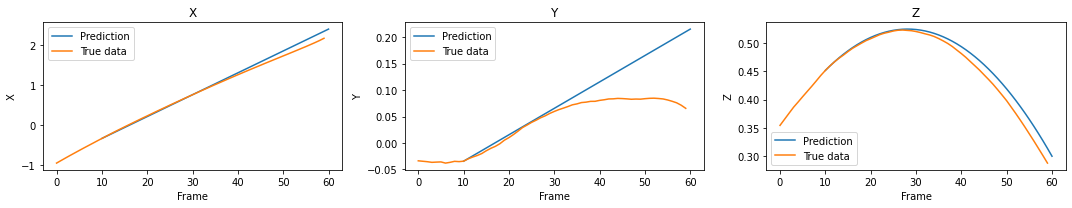

In [21]:
#TEST = trajectory_(1,traj_after['x'], traj_after['y'], traj_after['z'], slope_VZ, 15, slope_X, slope_Y)
plot_result(TEST.index[start:end+1], [TEST['X'][start:end+1], TEST['Y'][start:end+1], TEST['Z'][start:end+1]], 
            ['X', 'Y', 'Z'], ['Frame', 'Frame', 'Frame'], ['X', 'Y', 'Z'], 
            ['Prediction', 'True data'], traj_after.index[:60] , [X[:60], Y[:60], Z[:60]])
# [X[:-8], Y[:-8], Z[:-8]] 可用 [traj_after['x'].iloc[:-8], traj_after['y'].iloc[:-8], traj_after['z'].iloc[:-8]] 代替

## 計算各軸殘差平方和（誤差平方和）
Residual sum of squares (RSS) / Sum of squares error (SSE)  
僅針對預測資料與實際資料 index 一樣且均為整數的資料  
應該可以優化只不過目前沒有這個打算  
這裡計算從真實資料第 15 列到第 60 列的殘差平方和

### SSE_函式

In [22]:
# 僅供 predict data 和 true data的 index 均為整數且一致
# calculate Residual sum of squares(RSS)/sum of squares error(SSE) = 2-norm residuals vector **2
def SSE_(predict_data, true_data):
    import numpy as np
    sse = sum([(true_data[i]-predict_data[i])**2 for i in predict_data.index])
    #for i in predict_data.index:
    #    print(i, true_data[i], predict_data[i])
    print('sum of squares error =', sse)
    return(sse)

In [23]:
# 可以不用寫 start
sse_X = SSE_(TEST['X'][start:end+1], traj_after['x'])
sse_Y = SSE_(TEST['Y'][start:end+1], traj_after['y'])
sse_Z = SSE_(TEST['Z'][start:end+1], traj_after['z'])

sum of squares error = 0.35405147211806876
sum of squares error = 0.18352648197889732
sum of squares error = 0.010040269177732767


#### Check 用

In [24]:
for i in TEST['X'][start: start+5].index:
    print(i, traj_after['x'][i], TEST['X'][i])

10 -0.33984799999999993 -0.33984799999999993
11 -0.280516 -0.2850254565413533
12 -0.22187999999999997 -0.23020291308270668
13 -0.16345239999999994 -0.17538036962406006
14 -0.10660167999999999 -0.12055782616541344


In [25]:
TEST['X'].head()

10   -0.339848
11   -0.285025
12   -0.230203
13   -0.175380
14   -0.120558
Name: X, dtype: float64

In [26]:
traj_after['x'][15:20]

15   -0.049674
16    0.005922
17    0.061256
18    0.116641
19    0.172130
Name: x, dtype: float64

## 落點預測
基於不確定最低點（碰到桌面時的 Z 座標）為何，因此假設`traj_after['z'].iloc[60]`的值代表碰到桌面。（之前提過）  
欲從我們預測座標的倒數兩筆，分別對 X, Y 軸找到其對應函數 X(Z), Y(Z)，找到在碰到桌面的情況下時，所對應的X, Y座標（找解問題）

In [27]:
traj_after['z'].iloc[60]

0.27521199999999996

In [28]:
TEST.tail(2)

,X,Y,Z,$V_X$(m/s),$V_Y$(m/s),$V_Z$(m/s)
61,2.456102,0.220305,0.286086,0.054823,0.004995,-0.014726
62,2.510924,0.225300,0.271361,0.054823,0.004995,-0.015167


用線性迴歸的方式，找到最恰當的方程式來描述彼此間的關係（因為Frame之間時間間隔小，且只取較鄰近的）

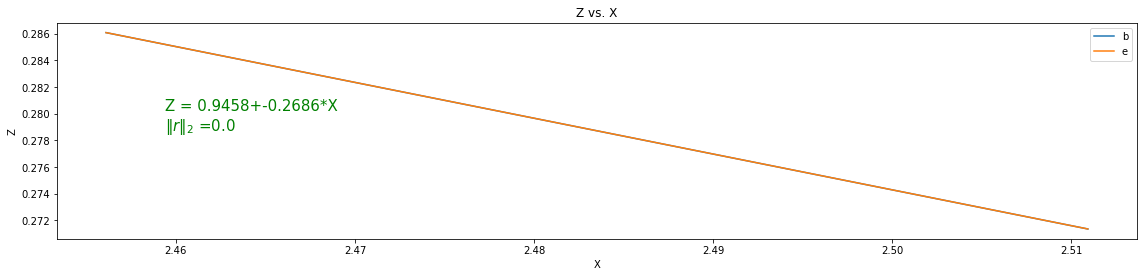

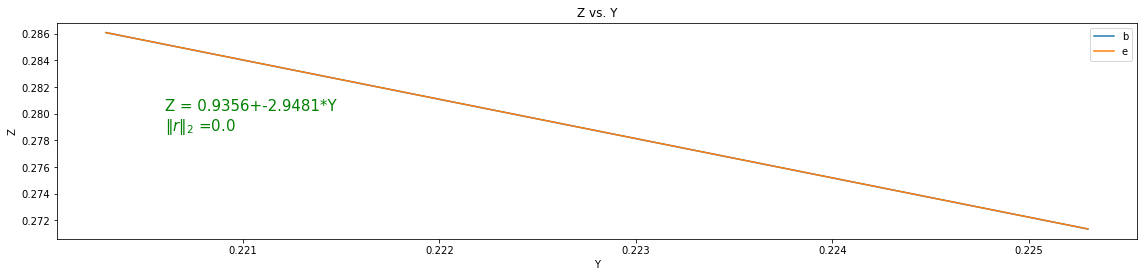

In [29]:
slope_XZ, intercept_XZ, r_XZ = linear_regression(['Z vs. X', 'X', 'Z'], TEST['X'][-2:], TEST['Z'][-2:])
slope_YZ, intercept_YZ, r_YZ = linear_regression(['Z vs. Y', 'Y', 'Z'], TEST['Y'][-2:], TEST['Z'][-2:])

### 牛頓迭代法
到了找解的過程拉～～～

### Newton函式

In [30]:
def Newton(x,f,df,tol):
    import math
    i = 0
    index = np.array([i])
    x_i = np.array([x])
    newton = np.array(['i','x_i','error','gamma'])
    err = 3*tol
    if err<=tol:
        return('tolrence too large')
    else:
        while err>tol:
            z = f(x)/df(x)
            err = abs(z)
            x = x-z
            i+=1
            x_i = np.vstack((x_i,[x]))
            index = np.vstack((index,[i]))
            #print(x,err)
        
        error = abs(x_i-x)
        gamma = np.zeros(len(error)).reshape(len(error),1)
        for j in range(len(error)):
            if j>0 and error[j]!=0:
                gamma[j] = math.log(error[j])/math.log(error[j-1])
                
        newton = np.vstack((newton,np.hstack((index,x_i,error,gamma))))
        dataframe = pd.DataFrame(newton)
        
        dataframe.columns = dataframe.iloc[0]
        dataframe = dataframe.drop(dataframe.index[0])     
        
        dataframe = dataframe.set_index('i')
        return(x_i[-1][0], dataframe)


#### Z vs. X

In [31]:
def XZ(X, slope=slope_XZ, intercept=intercept_XZ, zlimit=traj_after['z'].iloc[60]):
    return(slope*X + intercept - zlimit)
def dXZ(X, slope=slope_XZ):
    return(slope)
ans_XZ, df_XZ = Newton(TEST['X'].iloc[-2], XZ, dXZ,1e-10)
df_XZ

,x_i,error,gamma
i,,,
0.0,2.4561017163909797,0.040484033511577255,0.0
1.0,2.496585749902557,0.0,0.0
2.0,2.496585749902557,0.0,0.0


In [32]:
print('牛頓迭代法得到結果（X座標）:', ans_XZ)
print('牛頓迭代法得到結果回推 Z 座標:', XZ(ans_XZ)+traj_after['z'].iloc[60])

牛頓迭代法得到結果（X座標）: 2.496585749902557
牛頓迭代法得到結果回推 Z 座標: 0.2752119999999999


### 內插法
[示意]
$$
\frac{Z[-1]-0.2752}{Z[-1]-Z[-2]} = \frac{X[-1]-???}{X[-1]-X[-2]} 
$$

In [33]:
inter_XZ = TEST['X'].iloc[-1] - (TEST['X'].iloc[-1]-TEST['X'].iloc[-2])*(TEST['Z'].iloc[-1]-traj_after['z'].iloc[60])/(TEST['Z'].iloc[-1]-TEST['Z'].iloc[-2])
print('內插法得到結果（X座標）:', inter_XZ)
print('內插法得到結果回推 Z 座標:', XZ(inter_XZ)+traj_after['z'].iloc[60])

內插法得到結果（X座標）: 2.4965857499028994
內插法得到結果回推 Z 座標: 0.27521199999990786


#### Z vs. Y

In [34]:
# 可以把 YZ 和 dYZ 的 X 改為 Y，但沒這個必要
def YZ(X, slope=slope_YZ, intercept=intercept_YZ, zlimit=traj_after['z'].iloc[60]):
    return(slope*X + intercept - zlimit)
def dYZ(X, slope=slope_YZ):
    return(slope)
ans_YZ, df_YZ = Newton(TEST['Y'].iloc[-2], YZ, dYZ,1e-10)
df_YZ

,x_i,error,gamma
i,,,
0.0,0.22030456496240589,0.0036886448903456215,0.0
1.0,0.22399320985275153,2.7755575615628914e-17,6.804662434063439
2.0,0.2239932098527515,0.0,0.0


In [35]:
print('牛頓迭代法得到結果（Y座標）:', ans_YZ)
print('牛頓迭代法得到結果回推 Z 座標:', YZ(ans_YZ)+traj_after['z'].iloc[60])
inter_YZ = TEST['Y'].iloc[-1] - (TEST['Y'].iloc[-1]-TEST['Y'].iloc[-2])*(TEST['Z'].iloc[-1]-traj_after['z'].iloc[60])/(TEST['Z'].iloc[-1]-TEST['Z'].iloc[-2])
print('內插法得到結果（Y座標）:', inter_YZ)
print('內插法得到結果回推 Z 座標:', YZ(inter_YZ)+traj_after['z'].iloc[60])

牛頓迭代法得到結果（Y座標）: 0.2239932098527515
牛頓迭代法得到結果回推 Z 座標: 0.275212
內插法得到結果（Y座標）: 0.22399320985262133
內插法得到結果回推 Z 座標: 0.2752120000003838


### 落點結果比對

In [36]:
print('真實資料，假設第 60 個 Frame 碰到桌面（落點座標），此時的座標:\n(x, y, z) =', 
       (round(traj_after['x'].iloc[60], 5),  round(traj_after['y'].iloc[60], 5),  round(traj_after['z'].iloc[60], 5)))
print('\n用第 10 ~ 30 個 Frame，經線性回歸 + 牛頓迭代法得到的落點座標:\n(x, y, z) =', 
       (round(ans_XZ, 5), round(ans_YZ, 5), round(YZ(ans_YZ)+traj_after['z'].iloc[60], 5)))
print('\n用第 10 ~ 30 個 Frame，經線性回歸 + 內插法得到的落點座標:\n(x, y, z) =', 
       (round(inter_XZ, 5), round(inter_YZ, 5), round(YZ(inter_YZ)+traj_after['z'].iloc[60], 5)))

真實資料，假設第 60 個 Frame 碰到桌面（落點座標），此時的座標:
(x, y, z) = (2.23604, 0.05471, 0.27521)

用第 10 ~ 30 個 Frame，經線性回歸 + 牛頓迭代法得到的落點座標:
(x, y, z) = (2.49659, 0.22399, 0.27521)

用第 10 ~ 30 個 Frame，經線性回歸 + 內插法得到的落點座標:
(x, y, z) = (2.49659, 0.22399, 0.27521)


In [37]:
((traj_after['x'].iloc[60]-ans_XZ)**2 + (traj_after['y'].iloc[60]-ans_YZ)**2 + (traj_after['z'].iloc[60]-(YZ(ans_YZ)+traj_after['z'].iloc[60]))**2)**0.5

0.310707688727785

### 落點時間

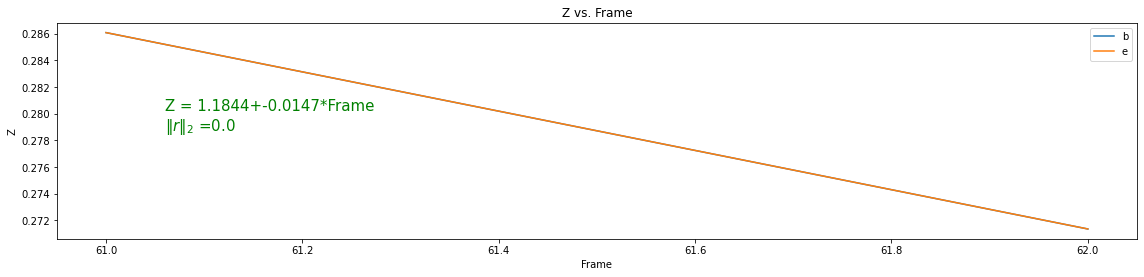

In [38]:
slope_TZ, intercept_TZ, r_TZ = linear_regression(['Z vs. Frame', 'Frame', 'Z'], TEST.index[-2:], TEST['Z'][-2:])

In [39]:
def TZ(X, slope=slope_TZ, intercept=intercept_TZ, zlimit=traj_after['z'].iloc[60]):
    return(slope*X + intercept - zlimit)
def dTZ(X, slope=slope_TZ):
    return(slope)
ans_TZ, df_TZ = Newton(TEST.index[-2], TZ, dTZ,1e-10)
df_TZ

,x_i,error,gamma
i,,,
0.0,61.0,0.7384559518373166,0.0
1.0,61.738455951837324,7.105427357601002e-15,107.44914599872652
2.0,61.73845595183732,0.0,0.0


牛頓迭代法預測落點的 Frame 為 61.738，相較於一開始令 Frame 60 作為真實落點

---
# Part2.物理模型~
依物理模型所建出來的資料作為數據（1V_0.62089_0.73994_0.25882W_31.4159_0_0.csv）
## 讀取資料（目前只測試第一筆）

### 由於資料讀入會自動把第一列算為 Header ，因此作了以下處理，把 Header 改為 x, y, z，並將第一列資料放回原來的位置

In [40]:
import pandas as pd
data1 = pd.read_csv("1V_0.62089_0.73994_0.25882W_31.4159_0_0.csv")
column = data1.columns
aa = pd.DataFrame([[float(i) for i in data1.columns]]).rename(columns = {0: 't', 1: 'x', 2: 'y', 3: 'z'})
data1 = data1.rename(columns = {column[0]: 't', column[1]: 'x', column[2]: 'y', column[3]: 'z'})

### 將時間做為 index

In [41]:
data1 = pd.concat([aa, data1], ignore_index=True)
data1 = data1.set_index(['t'])
data1.head()

,x,y,z
t,,,
0.00,0.38125,-0.050000,0.15250
0.01,0.38746,-0.042601,0.15460
0.02,0.39367,-0.035201,0.15571
0.03,0.39988,-0.027802,0.15585
0.04,0.40609,-0.020402,0.15500


## 繪製3D軌跡圖
#### 試著畫桌面和網子，但邊界數據依個人想讓這筆軌跡紀錄合理而亂調（雖然做完桌球桌看起來也不怎麼合理）

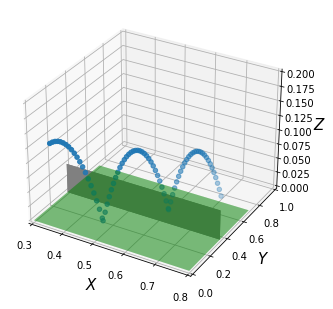

In [42]:
import matplotlib.pyplot as plt  
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure()
ax = p3.Axes3D(fig)


# Setting the axes properties
ax.set_xlim3d([0.3, 0.8])
ax.set_xlabel('X')
ax.set_ylim3d([0, 1])
ax.set_ylabel('Y')
ax.set_zlim3d([0.0, 0.2])
ax.set_zlabel('Z')


# Data for three-dimensional scattered points
zdata = data1[['z']]#.iloc[:21]
xdata = data1[['x']]#.iloc[:21]
ydata = data1[['y']]#.iloc[:21]
ax.scatter3D(xdata, ydata, zdata)

ax.set_xlabel('$X$', fontsize = 15)
ax.set_ylabel('$Y$', fontsize = 15)
ax.set_zlabel('$Z$', fontsize = 15)

net_x1 = .3
net_x2 = .8
net_y = .35
net_z = .1525/3

table_x1 = .3
table_x2 = .8
table_y1 = 0
table_y2 = .7
table_z = 0

# 網子
verts = [(net_x1, net_y, 0), (net_x1, net_y, 0), (net_x2, net_y, 0), (net_x2, net_y, 0), 
         (net_x1, net_y, net_z), (net_x1, net_y, net_z), (net_x2, net_y, net_z), (net_x2, net_y, net_z)]
faces = [[0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4], [1, 2, 6, 5], [2, 3, 7, 6], [0, 3, 7, 4]]

# 桌
verts2 = [(table_x1, table_y1, 0), (table_x1, table_y1, 0), (table_x2, table_y1, 0), (table_x2, table_y1, 0), 
          (table_x1, table_y2, 0), (table_x1, table_y2, 0), (table_x2, table_y2, 0), (table_x2, table_y2, 0)]

# 獲得每個面的頂點
poly3d = [[verts[vert_id] for vert_id in face] for face in faces]
poly3d2 = [[verts2[vert_id] for vert_id in face] for face in faces]
# 繪製多邊形面
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='gray', linewidths=1, alpha=1))
ax.add_collection3d(Poly3DCollection(poly3d2, facecolors='g', linewidths=1, alpha=0.3))



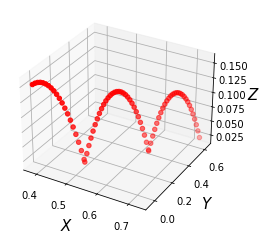

In [43]:
plot_3D(data1[['x']], data1[['y']], data1[['z']])

### 針對第一次的落下的資料做為要預測的資料，這裡取第一次落地前的數據，再進行一次作圖

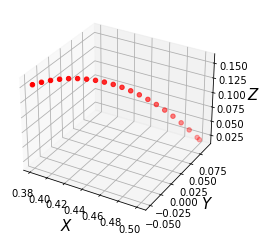

In [44]:
plot_3D(data1[['x']].iloc[:21], data1[['y']].iloc[:21], data1[['z']].iloc[:21])

In [45]:
data1.iloc[18:23]

,x,y,z
t,,,
0.18000,0.49301,0.083190,0.040165
0.19000,0.49922,0.090589,0.024605
0.19284,0.50098,0.092694,0.020000
0.20284,0.50526,0.102050,0.034288
0.21284,0.50955,0.111410,0.047595


### 三軸座標（位移）作圖

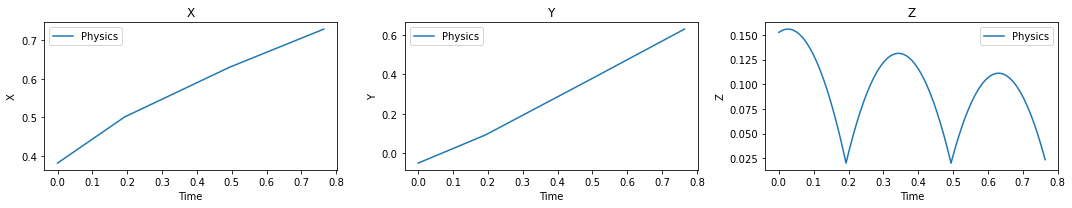

In [46]:
plot_result(data1.index, [data1[['x']], data1[['y']], data1[['z']]], 
            ['X', 'Y', 'Z'], ['Time', 'Time', 'Time'], ['X', 'Y', 'Z'], 
            ['Physics'])

## 計算速度並作圖

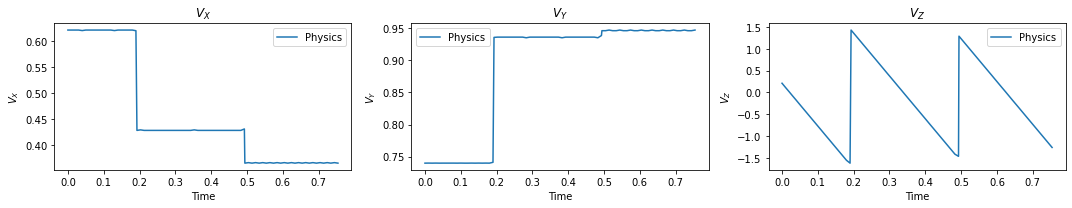

In [47]:
# https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array
from scipy.ndimage.interpolation import shift
V_X = ((shift(data1['x'], -1, cval=np.NaN) - data1['x'])/(shift(data1.index, -1, cval=np.NaN) - data1.index))
V_Y = ((shift(data1['y'], -1, cval=np.NaN) - data1['y'])/(shift(data1.index, -1, cval=np.NaN) - data1.index))
V_Z = ((shift(data1['z'], -1, cval=np.NaN) - data1['z'])/(shift(data1.index, -1, cval=np.NaN) - data1.index))
plot_result(data1.index, [V_X, V_Y, V_Z], 
            ['$V_X$', '$V_Y$', '$V_Z$'], ['Time', 'Time', 'Time'], ['$V_X$', '$V_Y$', '$V_Z$'], 
            ['Physics'])

## 建立線性迴歸模型並作圖
### 針對這筆資料的第五列到第九列（含）的座標數據作為迴歸的數據
### 也就是假設我們只知道這五列座標數據

- 三軸座標（位移）

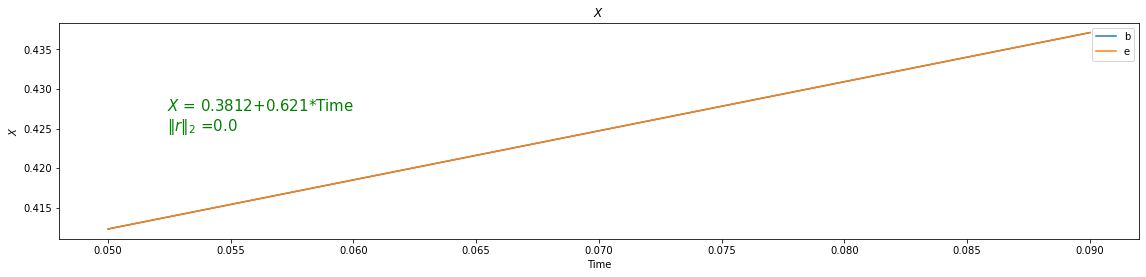

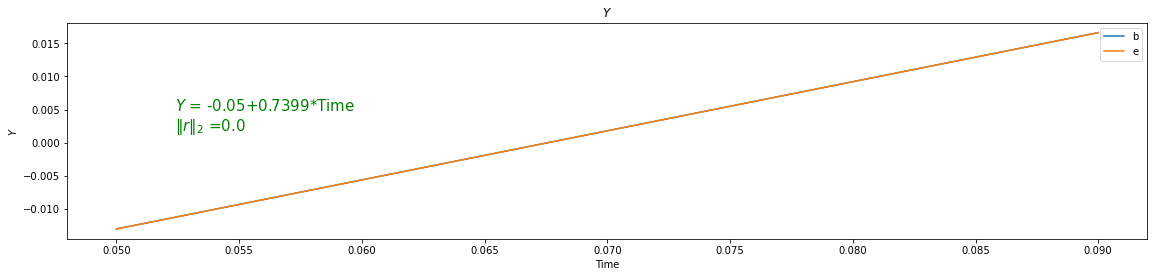

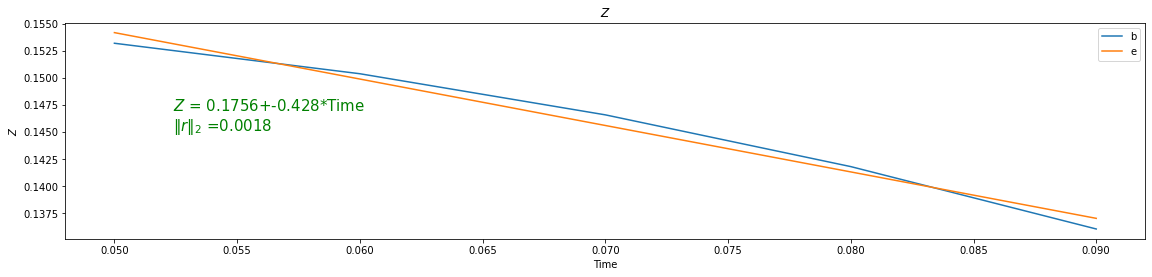

In [48]:
slope_X, intercept_X, r_X = linear_regression(['$X$', 'Time', '$X$'], data1.index[5:10], data1['x'].iloc[5:10])
slope_Y, intercept_Y, r_Y = linear_regression(['$Y$', 'Time', '$Y$'], data1.index[5:10], data1['y'].iloc[5:10])
slope_Z, intercept_Z, r_Z = linear_regression(['$Z$', 'Time', '$Z$'], data1.index[5:10], data1['z'].iloc[5:10])

- 針對 Z 變化量（速度）

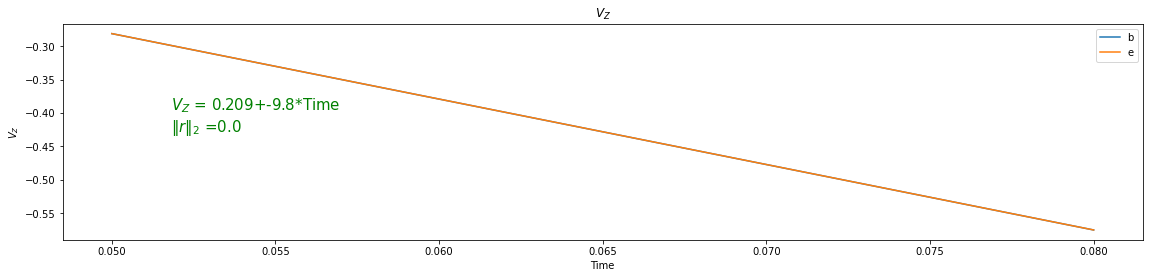

In [49]:
#from scipy.ndimage.interpolation import shift
#V_Z = ((shift(data1['z'], -1, cval=np.NaN) - data1['z'])/(shift(data1.index, -1, cval=np.NaN) - data1.index))
slope_VZ, intercept_VZ, r_VZ = linear_regression(['$V_Z$', 'Time', '$V_Z$'], data1.index[5:9], V_Z.iloc[5:9])

## 軌跡預測分析
### 用迴歸係數作參數進行預測
### 以不同的紀錄點時間差（$\Delta t$＝0.01, 0.001, 0.0001, 0.005）進行第一次落點（`data1.iloc[20]`）的預測  
**code可以優化但目前就維持這樣**
#### 在固定 $\Delta t$ 的情況下，只能記錄到在 z = 0.02 的前後 （不太可能有剛好 z = 0.02 的情況）

### trajectory函數

In [50]:
# 分開來看 (分成上面提到的前兩個矩陣的部分)
def trajectory(delta_t, X, Y, Z, g, index, VX0=None, VY0=None, xlimit=1.525, ylimit=2.74 , zlimit=0.02):
    
    matrix = np.diag(np.array([1.,1.,1.,1.,1.,1.])) + np.diag(np.array([delta_t,delta_t,delta_t]), k=3)
    matrix_Z = np.array([[1,delta_t], [0,1]])
    
    if VX0 == None:
        VX0 = (X.iloc[index+1]-X.iloc[index])/(X.index[index+1]-X.index[index])
    if VY0 == None:
        VY0 = (Y.iloc[index+1]-Y.iloc[index])/(X.index[index+1]-X.index[index])
    VZ0 = (Z.iloc[index+1]-Z.iloc[index])/(X.index[index+1]-X.index[index])
    VZ = np.array([VZ0, g])
    
    state = np.array([X.iloc[index], Y.iloc[index], Z.iloc[index], VX0, VY0, VZ0])
    df = pd.DataFrame([state], columns=['X', 'Y', 'Z', '$V_X$(m/s)', '$V_Y$(m/s)', '$V_Z$(m/s)'])   

    while state[2] >= zlimit and state[0] <= xlimit and state[1] <= ylimit:
        VZ = matrix_Z.dot(VZ)
        state = matrix.dot(state)
        
        df_temp = pd.DataFrame([state], columns=['X', 'Y', 'Z', '$V_X$(m/s)', '$V_Y$(m/s)', '$V_Z$(m/s)'])
        df_temp['$V_Z$(m/s)'] = VZ[0]
        df = pd.concat([df, df_temp])
        df.index = [i*delta_t for i in range(len(df))]
        df.index = df.index + X.index[index]
        
        state[5] = VZ[0]
        
        if abs(state[1]-ylimit/2) < zlimit and state[2] < zlimit+0.1525:
            break
        
    return(df)

### trajectory2函數

In [51]:
# 合在一起來看 (上述提到的最後一個矩陣形式)
def trajectory2(delta_t, X, Y, Z, g, index, VX0=None, VY0=None, xlimit=1.525, ylimit=2.74 , zlimit=0.02):
    
    matrix = np.diag(np.array([1.,1.,1.,1.,1.,1.,1.]))
    matrix[0,3], matrix[1,4], matrix[2,5], matrix[5,6] = delta_t, delta_t, delta_t, delta_t
    matrix_Z = np.array([[1,delta_t], [0,1]])
    
    if VX0 == None:
        VX0 = (X.iloc[index+1]-X.iloc[index])/(X.index[index+1]-X.index[index])
    if VY0 == None:
        VY0 = (Y.iloc[index+1]-Y.iloc[index])/(X.index[index+1]-X.index[index])
    VZ0 = (Z.iloc[index+1]-Z.iloc[index])/(X.index[index+1]-X.index[index])
    VZ = np.array([VZ0, g])
    
    state = np.array([X.iloc[index], Y.iloc[index], Z.iloc[index], VX0, VY0, VZ0, g])
    df = pd.DataFrame([state[:-1]], columns=['X', 'Y', 'Z', '$V_X$(m/s)', '$V_Y$(m/s)', '$V_Z$(m/s)'])   

    while state[2] >= zlimit and state[0] <= xlimit and state[1] <= ylimit:
        state = matrix.dot(state)
        
        df_temp = pd.DataFrame([state[:-1]], columns=['X', 'Y', 'Z', '$V_X$(m/s)', '$V_Y$(m/s)', '$V_Z$(m/s)'])
        df = pd.concat([df, df_temp])
        df.index = [i*delta_t for i in range(len(df))]
        df.index = df.index + X.index[index]
        
        if abs(state[1]-ylimit/2) < zlimit and state[2] < zlimit+0.1525:
            break      
            
    return(df)

### 預測座標比對
以 t = 0.01，index = 5 代入，代表從第五列座標開始，以時間間隔為 0.01 秒預測座標  
將預測座標前五項與實際座標比對（觀測）

In [52]:
TTEST = trajectory(0.01, data1['x'], data1['y'], data1['z'], slope_VZ, 5)
TTEST.head()

,X,Y,Z,$V_X$(m/s),$V_Y$(m/s),$V_Z$(m/s)
0.05,0.41229,-0.013003,0.15318,0.621,0.73995,-0.281
0.06,0.41850,-0.005603,0.15037,0.621,0.73995,-0.379
0.07,0.42471,0.001796,0.14658,0.621,0.73995,-0.477
0.08,0.43092,0.009196,0.14181,0.621,0.73995,-0.575
0.09,0.43713,0.016595,0.13606,0.621,0.73995,-0.673


In [53]:
data1.iloc[5:10]

,x,y,z
t,,,
0.05,0.41229,-0.013003,0.15318
0.06,0.41850,-0.005603,0.15037
0.07,0.42471,0.001796,0.14658
0.08,0.43092,0.009195,0.14181
0.09,0.43713,0.016595,0.13606


其他預測區間的軌跡預測

In [54]:
TTEST2 = trajectory(0.001, data1['x'], data1['y'], data1['z'], slope_VZ, 5)
TTEST3 = trajectory(0.0001, data1['x'], data1['y'], data1['z'], slope_VZ, 5)
TTEST4 = trajectory(0.005, data1['x'], data1['y'], data1['z'], slope_VZ, 5)

## 預測結果繪製

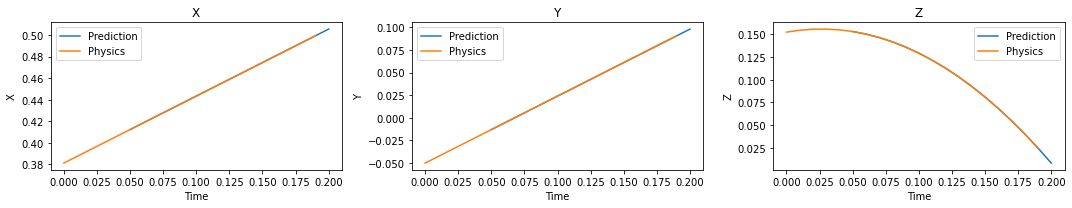

In [55]:
# TTEST: delta_t = 0.01
plot_result(TTEST.index, [TTEST['X'], TTEST['Y'], TTEST['Z']], 
            ['X', 'Y', 'Z'], ['Time', 'Time', 'Time'], ['X', 'Y', 'Z'], 
            ['Prediction', 'Physics'], data1.index[:20] , [data1['x'].iloc[:20], data1['y'].iloc[:20], data1['z'].iloc[:20]])

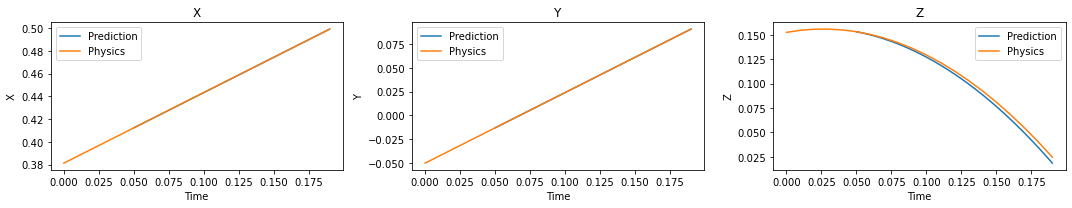

In [56]:
# TTEST2: delta_t = 0.001
plot_result(TTEST2.index, [TTEST2['X'], TTEST2['Y'], TTEST2['Z']], 
            ['X', 'Y', 'Z'], ['Time', 'Time', 'Time'], ['X', 'Y', 'Z'], 
            ['Prediction', 'Physics'], data1.index[:20] , [data1['x'].iloc[:20], data1['y'].iloc[:20], data1['z'].iloc[:20]])

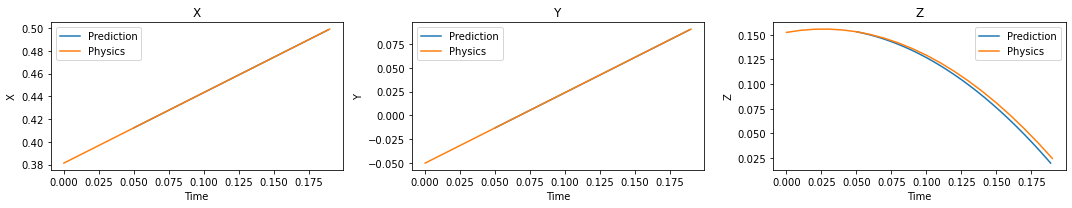

In [57]:
# TTEST3: delta_t = 0.0001
plot_result(TTEST3.index, [TTEST3['X'], TTEST3['Y'], TTEST3['Z']], 
            ['X', 'Y', 'Z'], ['Time', 'Time', 'Time'], ['X', 'Y', 'Z'], 
            ['Prediction', 'Physics'], data1.index[:20] , [data1['x'].iloc[:20], data1['y'].iloc[:20], data1['z'].iloc[:20]])

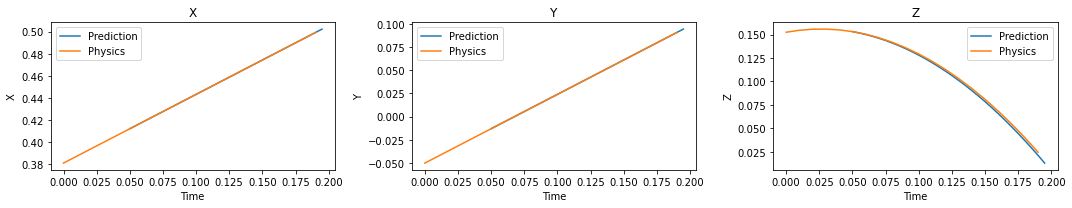

In [58]:
# TTEST4: delta_t = 0.005
plot_result(TTEST4.index, [TTEST4['X'], TTEST4['Y'], TTEST4['Z']], 
            ['X', 'Y', 'Z'], ['Time', 'Time', 'Time'], ['X', 'Y', 'Z'], 
            ['Prediction', 'Physics'], data1.index[:20] , [data1['x'].iloc[:20], data1['y'].iloc[:20], data1['z'].iloc[:20]])

## 計算殘差平方和（誤差平方和）

### 對預測資料以及物理模型資料的 index 進行處理（四捨五入到小數點第五位）

In [59]:
TEST_list = [TTEST, TTEST2, TTEST3, TTEST4]
for i in TEST_list:
    i.index = ([round(j, 5) for j in i.index])

data1_new_index = [round(i, 5) for i in data1.index]
data1.index = data1_new_index

### SSE函數

In [60]:
# calculate Residual sum of squares(RSS)/sum of squares error(SSE) = 2-norm residuals vector **2
def SSE(predict_data, true_data):
    import numpy as np
    index_list = [i for i in true_data.index for j in predict_data.index if i==j]#### 對預測資料以及物理模型資料的 index 進行處理（四捨五入到小數點第五位）
    sse = sum([(true_data[i]-predict_data[i])**2 for i in index_list])
    #print('sum of squares error =', sse)
    return(sse)

### 比較各個預測結果與真實資料，其三軸分別的SSE

In [61]:
sse_X_list, sse_Y_list, sse_Z_list = [], [], []
for i in TEST_list:
    sse_X_list.append(SSE(i['X'], data1['x']))
    sse_Y_list.append(SSE(i['Y'], data1['y']))
    sse_Z_list.append(SSE(i['Z'], data1['z']))
dfsse = pd.DataFrame([sse_X_list, sse_Y_list, sse_Z_list], 
                     columns=['0.01', '0.001', '0.0001', '0.005'], index=['x(m)', 'y(m)', 'z(m)']).transpose().sort_index(ascending = False)
dfsse.index.name = '$\Delta t(s)$'
dfsse
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html

,x(m),y(m),z(m)
$\Delta t(s)$,,,
0.01,6.000000e-10,5.270000e-12,7.673000e-09
0.005,6.000000e-10,5.270000e-12,5.972324e-05
0.001,6.000000e-10,5.270000e-12,1.952282e-04
0.0001,5.000000e-10,4.270000e-12,1.910850e-04


## 針對 Z 軸預測結果進行討論

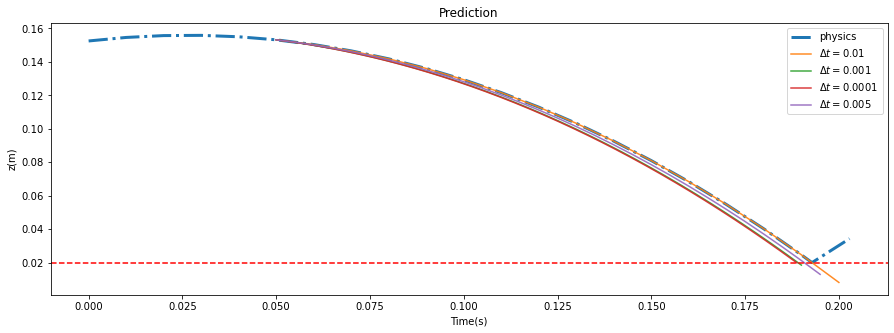

In [62]:
plt.figure(figsize=(15,5))
plt.plot(data1[['z']].iloc[:22], linewidth=3, linestyle='-.', label = 'physics')
plt.plot(TTEST['Z'], alpha=0.9, label = '$\Delta t=0.01$')
plt.plot(TTEST2['Z'], alpha=0.9, label = '$\Delta t=0.001$')
plt.plot(TTEST3['Z'], alpha=0.9, label = '$\Delta t=0.0001$')
plt.plot(TTEST4['Z'], alpha=0.9, label = '$\Delta t=0.005$')
plt.axhline(y=0.02, color='r', linestyle='--')
plt.legend()
plt.title('Prediction')
plt.xlabel('Time(s)')
plt.ylabel('z(m)')
plt.show()

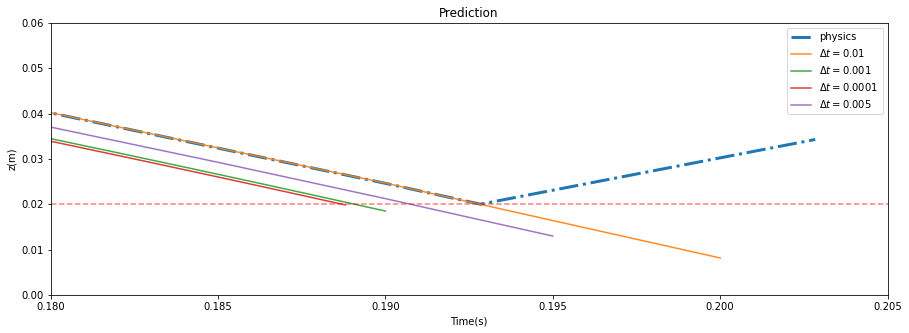

In [63]:
plt.figure(figsize=(15,5))
plt.plot(data1[['z']].iloc[:22], linewidth=3, linestyle='-.', label = 'physics')
plt.plot(TTEST['Z'], alpha=0.9, label = '$\Delta t=0.01$')
plt.plot(TTEST2['Z'], alpha=0.9, label = '$\Delta t=0.001$')
plt.plot(TTEST3['Z'], alpha=0.9, label = '$\Delta t=0.0001$')
plt.plot(TTEST4['Z'], alpha=0.9, label = '$\Delta t=0.005$')
plt.axhline(y=0.02, color='r', linestyle='--', alpha = 0.5)
plt.xlim(0.18, 0.205)
plt.ylim(0,0.06)
plt.legend()
plt.title('Prediction')
plt.xlabel('Time(s)')
plt.ylabel('z(m)')
plt.show()

## 落點預測（座標＋時間）
#### 對倒數兩筆的預測結果進行線性回歸（Z vs. X, Z vs. Y, Z vs. Time），並利用牛頓迭代法求解（也可以用內插法直接算啦但想說之前作業寫過就拿出來用了），找到與Z=0.02時個別所對應的值

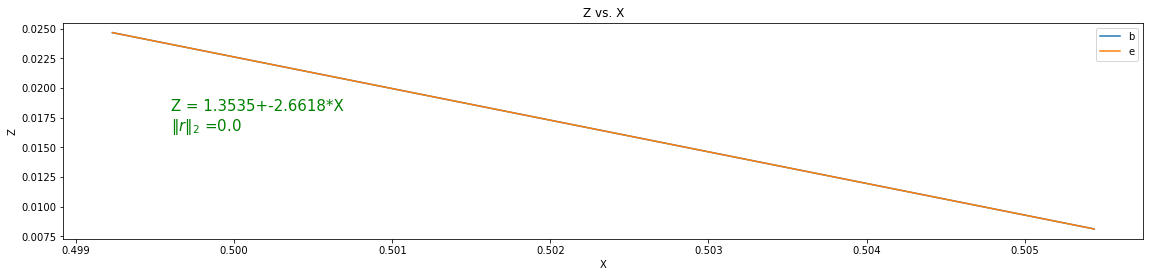

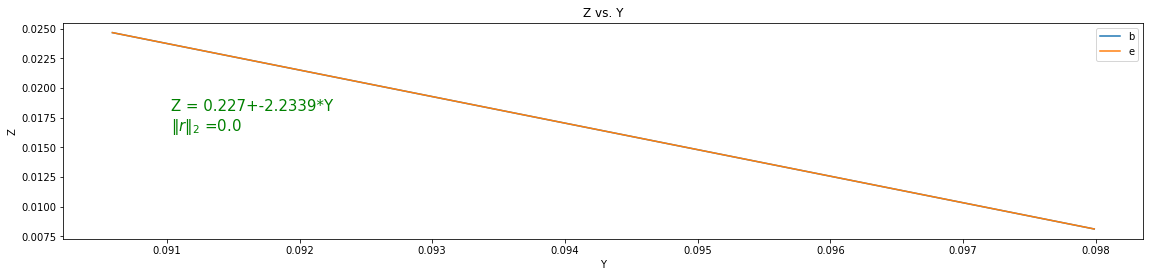

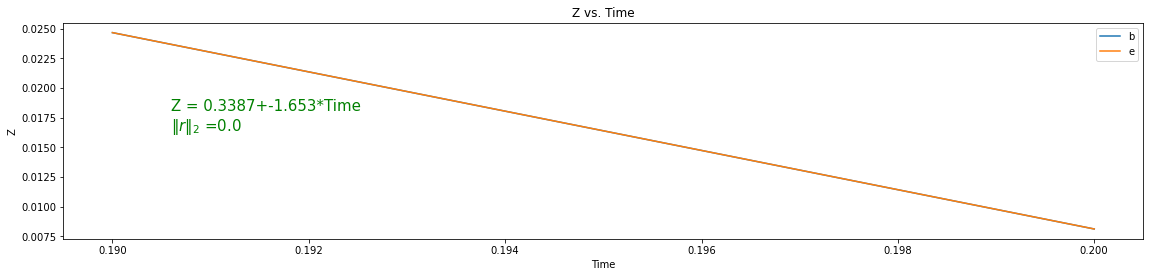

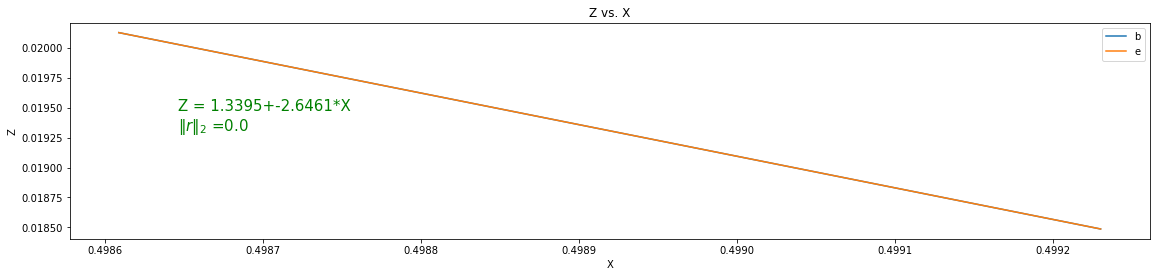

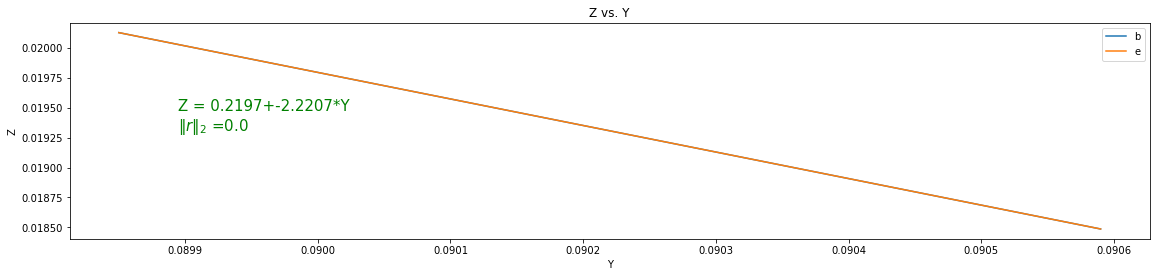

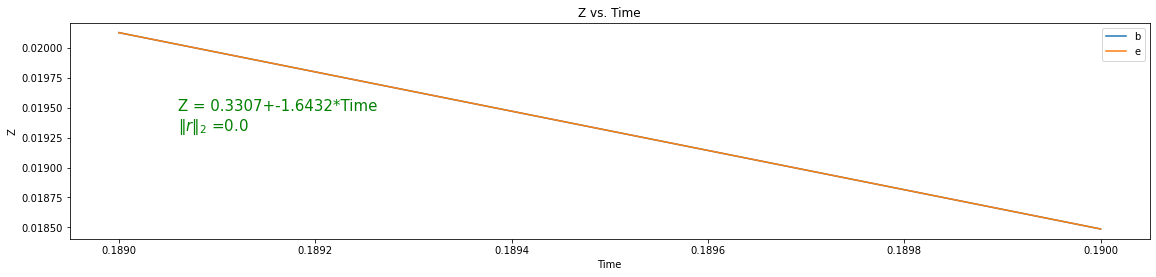

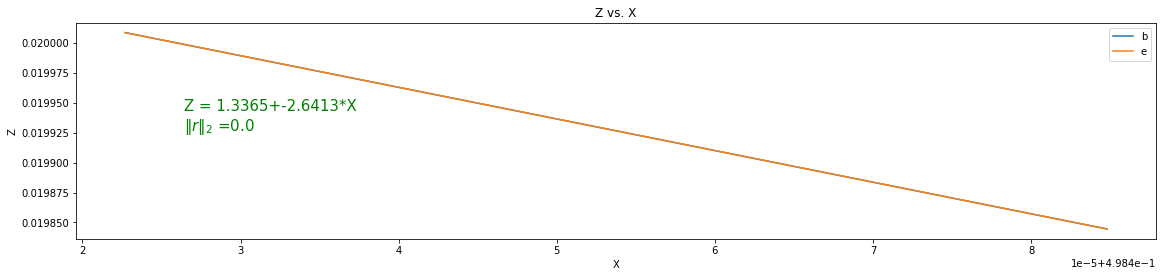

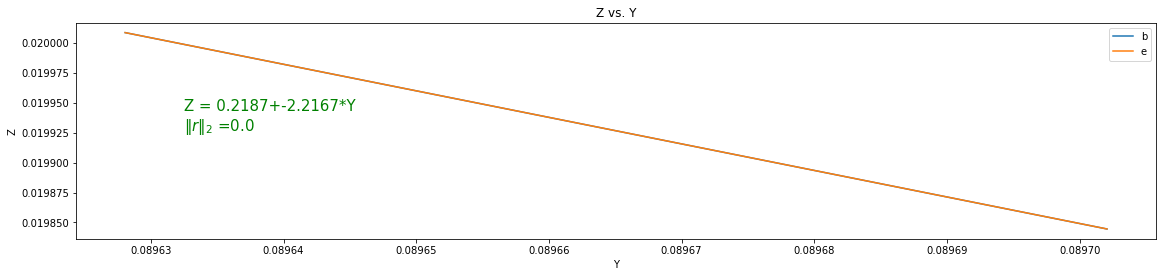

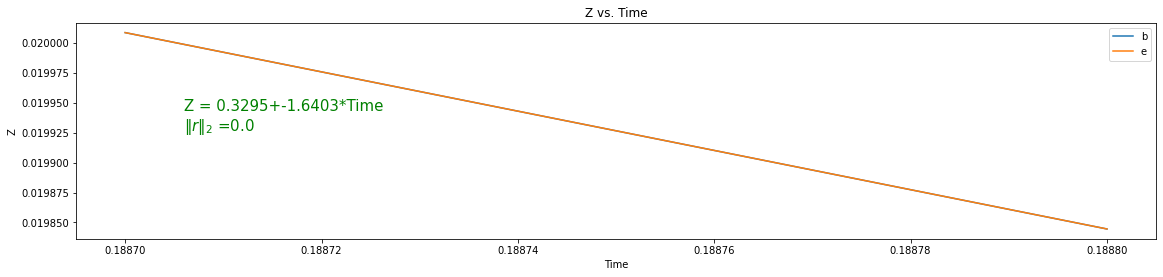

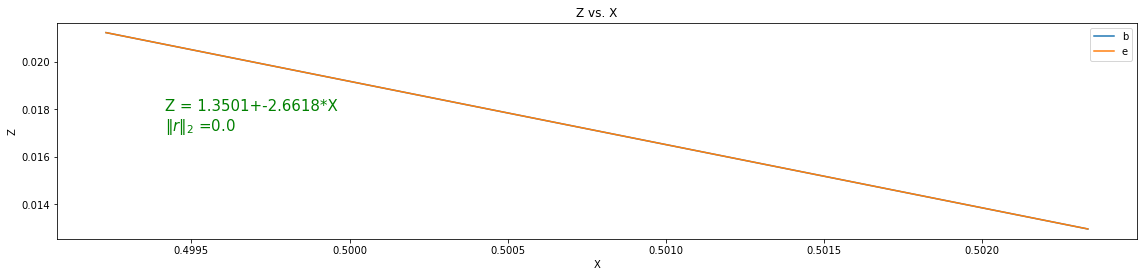

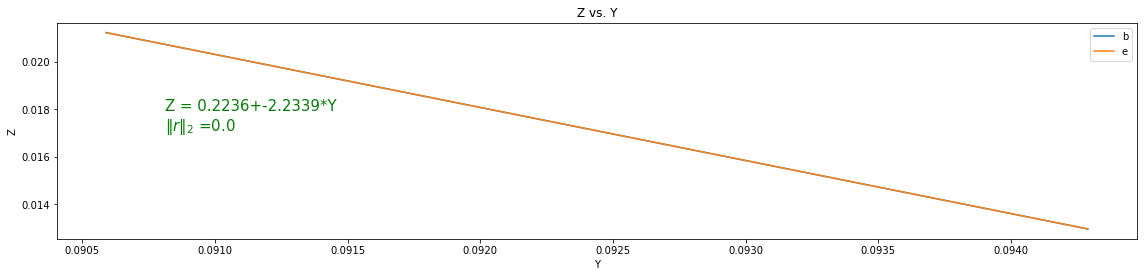

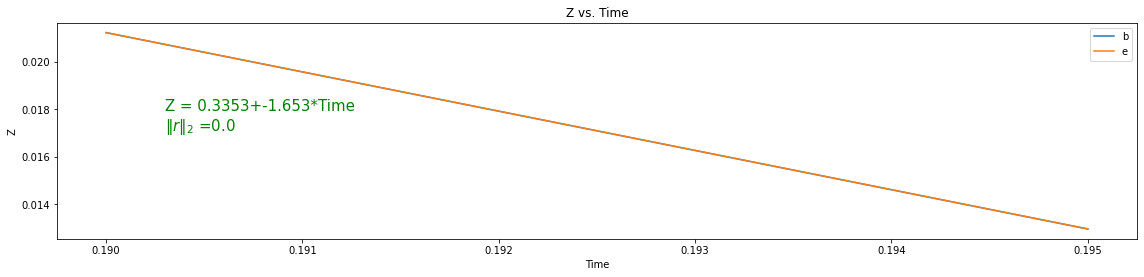

In [64]:
XZ_list, YZ_list, TZ_list = [], [], []   # slope, intercept, residual vector
for i in TEST_list:
    XZ_list.append(linear_regression(['Z vs. X', 'X', 'Z'], i['X'].iloc[-2:], i['Z'].iloc[-2:]))
    YZ_list.append(linear_regression(['Z vs. Y', 'Y', 'Z'], i['Y'].iloc[-2:], i['Z'].iloc[-2:]))
    TZ_list.append(linear_regression(['Z vs. Time', 'Time', 'Z'], i.index[-2:], i['Z'].iloc[-2:]))

In [65]:
newton_XZ = []    # ans_XZ, df_XZ
newton_YZ = []    # ans_YZ, df_YZ
newton_TZ = []    # ans_TZ, df_TZ

for i, j in enumerate(TEST_list):
    def XZ_(X, slope=XZ_list[i][0], intercept=XZ_list[i][1], zlimit=0.02):
        return(slope*X + intercept - zlimit)
    def dXZ_(X, slope=XZ_list[i][0]):
        return(slope)
    newton_XZ.append(Newton(j['X'].iloc[-2], XZ_, dXZ_,1e-10))
    
    def YZ_(X, slope=YZ_list[i][0], intercept=YZ_list[i][1], zlimit=0.02):
        return(slope*X + intercept - zlimit)
    def dYZ_(X, slope=YZ_list[i][0]):
        return(slope)
    newton_YZ.append(Newton(j['Y'].iloc[-2], YZ_, dYZ_,1e-10))
    
    def TZ_(X, slope=TZ_list[i][0], intercept=TZ_list[i][1], zlimit=0.02):
        return(slope*X + intercept - zlimit)
    def dTZ_(X, slope=TZ_list[i][0]):
        return(slope)
    newton_TZ.append(Newton(j.index[-2], TZ_, dTZ_,1e-10))

In [66]:
df_pred = pd.DataFrame(columns=['Time(s)', 'x(m)', 'y(m)', 'z(m)'], index=['0.01', '0.001', '0.0001', '0.005'])  # 可以把 index 用 int 形式但懶得改
for i in range(len(newton_XZ)):  # len(TEST_list), len(newton_YZ)也行
    df_pred.iloc[i][0] = newton_TZ[i][0]
    df_pred.iloc[i][1] = newton_XZ[i][0]   
    df_pred.iloc[i][2] = newton_YZ[i][0]
    df_pred.iloc[i][3] = 0.02    # 這裡 z值我直接帶 zlimit (不完全正確的作法, 應該要代入XZ_, YZ_, TZ_計算, 但把函數設成會變動的形式, 所以...)
    
df_pred.index.name = '$\Delta t(s)$'
df_pred = df_pred.sort_index(ascending=False)

#### 預測落點結果

In [67]:
df_pred

,Time(s),x(m),y(m),z(m)
$\Delta t(s)$,,,,
0.01,0.192819,0.500981,0.092676,0.02
0.005,0.190744,0.499692,0.0911406,0.02
0.001,0.189079,0.498658,0.0899082,0.02
0.0001,0.188705,0.498426,0.0896319,0.02


#### 與真實落點結果對照

In [68]:
data1.iloc[[20]]

,x,y,z
0.19284,0.50098,0.092694,0.02
